In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

Using TensorFlow backend.


In [2]:
working_path = "/work/05268/junma7/maverick/luna16/"
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
img_rows = 512
img_cols = 512
smooth = 1.

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [4]:
def get_unet():
    inputs = Input((1,img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)
    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    model.compile(optimizer=Adam(lr=1.0e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [30]:
imgs_test = np.load(working_path+"testImages.npy").astype(np.float32)
imgs_mask_test_true = np.load(working_path+"testMasks.npy").astype(np.float32)
model = get_unet()
model.load_weights(working_path+"unet.hdf5")
num_test = len(imgs_test)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
np.save(working_path+'masksTestPredicted.npy', imgs_mask_test)
mean = 0.0
for i in range(num_test):
    mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
mean/=num_test
print("Mean Dice Coeff : ",mean)

/home/05268/junma7/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/home/05268/junma7/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/home/05268/junma7/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/home/05268/junma7/.local/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same", activation="relu")`
  '` call to the Keras 2 API: ' + signature)
/home/05268/junma7

Mean Dice Coeff :  2.49203642389e-05


In [35]:
fileName="0088_0979.npy"
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
from glob import glob
file_list=glob("/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_"+fileName)
out_images = []      #final set of images
out_nodemasks = []   #final set of nodemasks
for fname in file_list:
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
#         new_mean = np.mean(img[mask>0])  
#         new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
#         old_min = np.min(img)       # background color
#         img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
#         img = img-new_mean
#         img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        #
        # Finding the global min and max row over all regions
        #
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = img/(max-min)
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            out_images.append(new_img)
            out_nodemasks.append(new_node_mask)

/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/

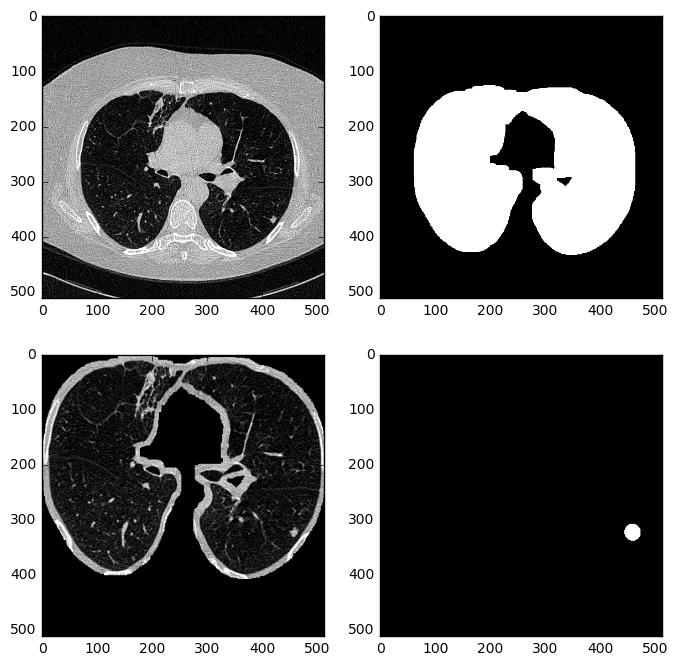

In [36]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,2,figsize=[8,8])

images=np.load("/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/images_"+fileName)
img=images[1]
lungmask=np.load("/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_"+fileName)
lmask=lungmask[1]
mask=np.load("/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/masks_"+fileName)

ax[0,0].imshow(img,cmap='gray')
ax[0,1].imshow(lmask,cmap='gray')
# ax[1,0].imshow(img*lmask,cmap='gray')
# ax[1,1].imshow(mask[1],cmap='gray')
# checkimage=out_images[0]
# checkimage[checkimage<604]=0
ax[1,0].imshow(out_images[0],cmap='gray')
ax[1,1].imshow(out_nodemasks[0],cmap='gray')
# ax[1,1].imshow(checkimage,cmap='gray')
plt.show()
# plt.savefig("lungseg.png",bbox_inches='tight')



In [ ]:
import matplotlib.pyplot as plt
data=np.load("/work/05268/junma7/maverick/luna16/"+"masksTestPredicted.npy")
data=np.load("/home/05268/junma7/luna16/masksTestPredicted.npy")
num=7
f, plots = plt.subplots(num, num, sharex='all', sharey='all', figsize=(num, num))


for i in range(num*num):
    plots[i // num, i % num].axis('off')
    plots[i // num, i % num].imshow(data[i+num][0], cmap=plt.cm.gray)
plt.show()

In [37]:
out_images[0][320:350,450:480]

array([[  1.21200956e-01,   1.35137840e-01,   2.10460429e-01,
          3.43812462e-01,   4.66660800e-01,   5.35582312e-01,
          5.38553109e-01,   6.04149229e-01,   6.20262166e-01,
          5.61109428e-01,   4.34195572e-01,   4.03447227e-01,
          3.65094919e-01,   2.75618891e-01,   1.49287539e-01,
          4.00506315e-02,  -5.10605703e-02,  -6.82836966e-02,
         -6.54629300e-02,  -7.46649820e-02,  -8.37818392e-02,
         -7.37045460e-02,  -2.12814054e-02,   9.30259383e-02,
          2.71295994e-01,   3.65077544e-01,   4.71166698e-01,
          5.04460912e-01,   4.81833542e-01,   4.97306941e-01],
       [  3.41564176e-01,   4.25023110e-01,   5.01022539e-01,
          5.78459524e-01,   6.36153776e-01,   6.53319031e-01,
          5.97081373e-01,   6.20574590e-01,   6.23975594e-01,
          5.74103103e-01,   4.65715705e-01,   4.40124158e-01,
          3.14069379e-01,   1.79303485e-01,   6.97266201e-02,
         -5.72800204e-03,  -6.83782263e-02,  -8.79224089e-02,
       

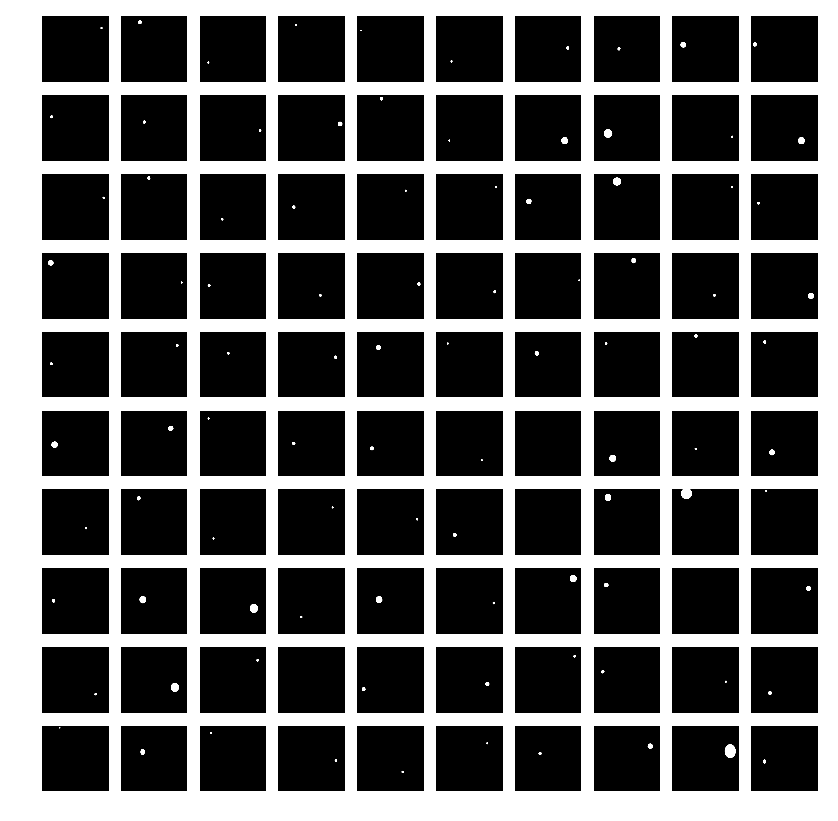

In [39]:
f, plots = plt.subplots(10, 10, sharex='all', sharey='all', figsize=(10, 10))

for i in range(100):
    plots[i // 10, i % 10].axis('off')
    plots[i // 10, i % 10].imshow(imgs_mask_test_true[i+10][0], cmap=plt.cm.gray)
plt.show()

In [20]:
out_nodemasks[0]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])